# Assign 1 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 

Help Source: [https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/](https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/)

In [6]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

In [7]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploring The Data

In [8]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten


In [9]:
# Identify Image Resolutions

# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
root_path = 'chest_xray\\train\\NORMAL\\'
imgs = [img.name for img in Path(root_path).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root_path+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 1341


,FileName,Size,Width,Height,Aspect Ratio
0,IM-0115-0001.jpeg,"(2090, 1858)",2090,1858,1.12
1,IM-0117-0001.jpeg,"(1422, 1152)",1422,1152,1.23
2,IM-0119-0001.jpeg,"(1810, 1434)",1810,1434,1.26
3,IM-0122-0001.jpeg,"(1618, 1279)",1618,1279,1.27
4,IM-0125-0001.jpeg,"(1600, 1125)",1600,1125,1.42


Text(0, 0.5, 'Height')

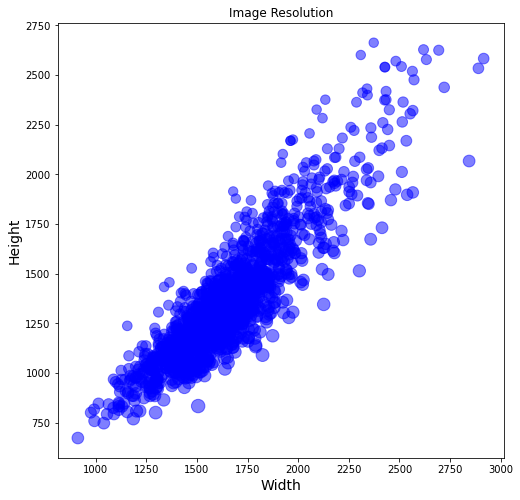

In [10]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

<h2>Loading The Data</h2>

In [11]:
# importing the data into variables

def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))

    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(300,300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(300,300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels 

In [12]:
norm_images, norm_labels = load_normal("chest_xray\\train\\NORMAL\\")
pneu_images, pneu_labels = load_pneumonia("chest_xray\\train\\PNEUMONIA\\")

100%|██████████| 3875/3875 [00:22<00:00, 172.91it/s]


In [13]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [14]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

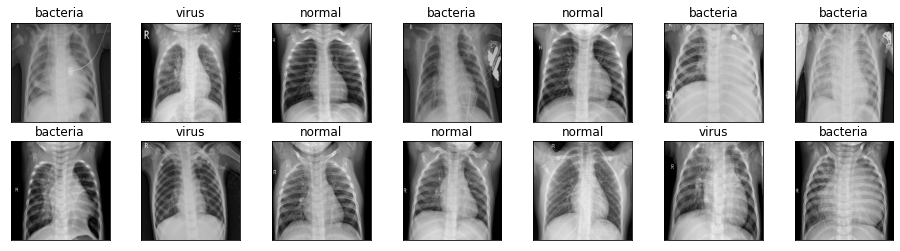

In [15]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [17]:
norm_images_test, norm_labels_test = load_normal("chest_xray\\test\\NORMAL\\")
pneu_images_test, pneu_labels_test = load_pneumonia("chest_xray\\test\\PNEUMONIA\\")
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:01<00:00, 199.19it/s]


In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [19]:
#testing the new shape of our data:

print(X_train.shape)
print(X_test.shape)

(5216, 300, 300, 1)
(16, 300, 300, 1)
(624, 300, 300, 1)


<h2>Building The Model</h2>

In [20]:
print(y_train)

['normal' 'normal' 'normal' ... 'bacteria' 'bacteria' 'bacteria']


In [21]:
num_classes = 3
input_shape = (300, 300, 1)

# Scale images to the [0, 1] range
X_train_normalized = X_train.astype("float32") / 255
X_test_normalized = X_test.astype("float32") / 255
# Make sure images have shape (200, 200, 1)
print(X_train_normalized.shape)
print(X_train_normalized.shape[0], "train samples")
print(X_test_normalized.shape[0], "test samples")

le = LabelEncoder()
le.fit(y_train)
y_train_le = le.transform(y_train)
le.fit(y_test)
y_test_le = le.transform(y_test)

# convert class vectors to binary class matrices
y_train_oh = keras.utils.to_categorical(y_train_le, num_classes)
y_test_oh = keras.utils.to_categorical(y_test_le, num_classes)

(5216, 300, 300, 1)
5216 train samples
624 test samples


In [22]:
print(y_train)
print(y_train_le)
print(y_train_oh)

['normal' 'normal' 'normal' ... 'bacteria' 'bacteria' 'bacteria']
[1 1 1 ... 0 0 0]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# Saving the imported data using pickle module

In [23]:
import pickle

# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train_normalized, X_test_normalized, y_train_oh, y_test_oh, num_classes, input_shape), f)

# Loading the imported data using pickle module

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train_normalized, X_test_normalized, y_train_oh, y_test_oh, num_classes, input_shape) = pickle.load(f)

# Basic Model (without convolution layers)

In [2]:
basic_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(10, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)  # No weights at this stage!

In [3]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400, 400, 10)      20        
                                                                 
 dense_1 (Dense)             (None, 400, 400, 6)       66        
                                                                 
 dense_2 (Dense)             (None, 400, 400, 2)       14        
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dropout (Dropout)           (None, 320000)            0         
                                                                 
 dense_3 (Dense)             (None, 3)                 960003    
                                                                 
Total params: 960,103
Trainable params: 960,103
Non-trai

In [4]:
batch_size = 64
epochs = 20

basic_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

basic_history = basic_model.fit(X_train_normalized, y_train_oh, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/20
70/70 [==============================] - 6s 79ms/step - loss: 1.0912 - accuracy: 0.4683 - val_loss: 1.0790 - val_accuracy: 0.5798
Epoch 2/20
69/70 [============================>.] - ETA: 0s - loss: 1.0790 - accuracy: 0.4688

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


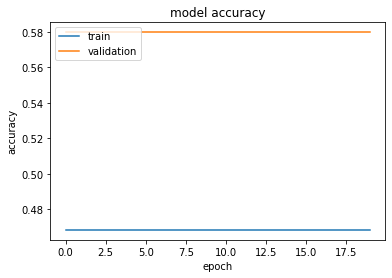

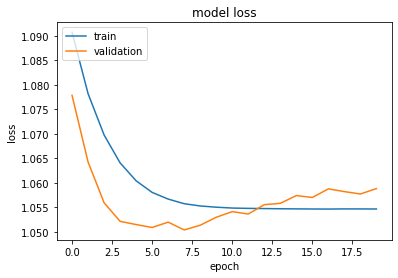

In [ ]:
# list all data in history
print(basic_history.history.keys())
# summarize history for accuracy
plt.plot(basic_history.history['accuracy'])
plt.plot(basic_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(basic_history.history['loss'])
plt.plot(basic_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Advanced Model (using convolution layers)

In [2]:
advanced_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
) 

In [3]:
advanced_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 8)       208       
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 16)      3216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                    

In [4]:
batch_size = 64
epochs = 25

advanced_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

advanced_history = advanced_model.fit(X_train_normalized, y_train_oh, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/25
66/66 [==============================] - 17s 180ms/step - loss: 1.0733 - accuracy: 0.4494 - val_loss: 1.0562 - val_accuracy: 0.6216
Epoch 2/25
66/66 [==============================] - 11s 174ms/step - loss: 1.0410 - accuracy: 0.4621 - val_loss: 0.9997 - val_accuracy: 0.6102
Epoch 3/25
66/66 [==============================] - 11s 166ms/step - loss: 0.9712 - accuracy: 0.5731 - val_loss: 0.8378 - val_accuracy: 0.6102
Epoch 4/25
66/66 [==============================] - 11s 165ms/step - loss: 0.8272 - accuracy: 0.6541 - val_loss: 1.2181 - val_accuracy: 0.4751
Epoch 5/25
66/66 [==============================] - 11s 165ms/step - loss: 0.7219 - accuracy: 0.6958 - val_loss: 0.9713 - val_accuracy: 0.6216
Epoch 6/25
66/66 [==============================] - 11s 165ms/step - loss: 0.6826 - accuracy: 0.6930 - val_loss: 1.2739 - val_accuracy: 0.3669
Epoch 7/25
66/66 [==============================] - 11s 165ms/step - loss: 0.5957 - accuracy: 0.7375 - val_loss: 0.7276 - val_accuracy: 0.6628

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


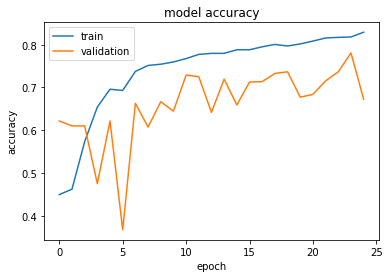

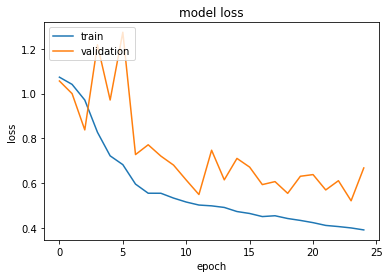

In [5]:
# list all data in history
print(advanced_history.history.keys())
# summarize history for accuracy
plt.plot(advanced_history.history['accuracy'])
plt.plot(advanced_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(advanced_history.history['loss'])
plt.plot(advanced_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()